In [87]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [88]:
train = pd.read_csv('mitbih_train.csv', header=None)
test = pd.read_csv('mitbih_test.csv', header=None)

In [89]:
train

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [90]:
class ECG(Dataset):
    def __init__(self, df:pd.DataFrame):
        self.X = df.drop(187) 
        self.Y = df[187] 

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.X.iloc[idx].values)
        y = torch.from_numpy(self.Y.iloc[[idx]].values)
        return x, y

In [91]:
train_loader = DataLoader(ECG(train), batch_size=32, shuffle=True)
test_loader = DataLoader(ECG(test), batch_size=32, shuffle=False)


# data preparation

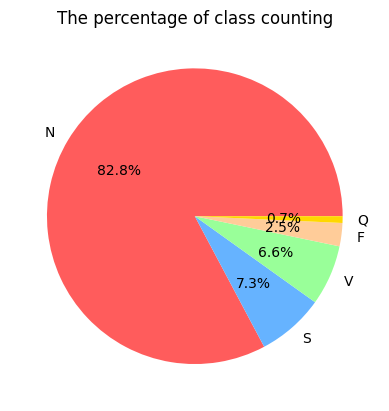

In [17]:
# Count values
plt.pie(train[187].value_counts(), labels=['N', 'S', 'V', 'F', 'Q'], autopct='%1.1f%%', colors = ['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('The percentage of class counting')
plt.show()

In [92]:
# define architecture
class ResualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=(5,5)):
        super(ResualBlock, self).__init__()
        self.conv0 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel, stride=(2,2), bias=False)
        self.relu0 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel, stride=(2,2), bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.pooling = nn.MaxPool1d(5, stride=(2,2))

    def forward(self, x):
        identity = x
        out = self.conv0(x)
        out = self.relu0(out)
        out = self.conv1(out)
        out += identity
        out = self.relu1(out)
        out = self.pooling(out)
        return out
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5),
            ResualBlock(32,64),
            ResualBlock(64,256),
            ResualBlock(256,512),
            ResualBlock(512,1024),
            ResualBlock(1024,2048)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(2048,32),
            nn.ReLU(inplace=True),
            nn.Linear(32,4),
            nn.Softmax(1),
    def 
        )

In [93]:
model = CNN()

In [94]:
# define train function  
class MyTrain():
    def __init__(self, model, train_loader, test_loader, epochs , criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.epochs = epochs

    def trainLoop(self, epochs):
        train_loss = []
        train_acc = []
        test_loss = []
        test_acc = []

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for i, (inputs, labels) in enumerate(self.train_loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step() 
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            train_loss.append(running_loss/len(self.train_loader))
            train_acc.append(100.*correct/total)

            self.model.eval()
            running_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for i, (inputs, labels) in enumerate(self.test_loader):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    running_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
            test_loss.append(running_loss/len(self.test_loader))
            test_acc.append(100.*correct/total)

            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Test Loss: {test_loss[-1]:.4f}, Test Acc: {test_acc[-1]:.2f}%')


        return train_loss, train_acc, test_loss, test_acc

In [95]:
# run data      
x = MyTrain(model=model, train_loader=train_loader, test_loader=test_loader, epochs=3, criterion=torch.nn.CrossEntropyLoss(), optimizer=optim.Adam(model.parameters(),lr=0.001), device=device)
x.trainLoop(3) # ok ok :>

NotImplementedError: Module [CNN] is missing the required "forward" function